In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import rc
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from math import exp, sqrt #, gamma

#import rpy2
#from rpy2 import robjects
#from rpy2.robjects import FloatVector
#from rpy2.robjects.packages import importr

#%load_ext rpy2.ipython

from scipy.optimize import curve_fit
import scipy.signal as ss
from scipy.stats import levy_stable, norm
from scipy.fft import fft, ifft
import scipy as scipy
import scipy.odr as odr
from scipy.integrate import simps
import scipy.special as sc
from scipy.special import gamma, factorial

import statsmodels.api as sm

In [3]:
#def calc_rms(x, scale, order):

#    shape = (x.shape[0]//scale, scale)
#    X = np.lib.stride_tricks.as_strided(x,shape=shape)

#    scale_ax = np.arange(scale)
#    rms = np.zeros(X.shape[0])
#    for e, xcut in enumerate(X):
#        coeff = np.polyfit(scale_ax, xcut, order) 
#        xfit = np.polyval(coeff, scale_ax)

#        rms[e] = np.sqrt(np.mean((xcut-xfit)**2))
#    return rms

#def dfa(x, order, scale_lim=[5,9], scale_dens=0.25):

#    y = np.cumsum(x - np.mean(x))
#    scales = (2**np.arange(scale_lim[0], scale_lim[1], scale_dens)).astype(np.int)
#    fluct = np.zeros(len(scales))

#    for e, sc in enumerate(scales):
#        fluct[e] = np.sqrt(np.mean(calc_rms(y, sc, order)**2))
        
#    coeff = np.polyfit(np.log2(scales), np.log2(fluct), 1)

#    return scales, fluct, coeff 


def __ma_model(
    params: list[float],
    n_points: int,
    *,
    noise_std: float = 1,
    noise_alpha: float = 2,
) -> list[float]:

    ma_order = len(params)
    if noise_alpha == 2:
        noise = norm.rvs(scale=noise_std, size=(n_points + ma_order))
    else:
        noise = levy_stable.rvs(
            noise_alpha, 0, scale=noise_std, size=(n_points + ma_order)
        )

    if ma_order == 0:
        return noise
    ma_coeffs = np.append([1], params)
    ma_series = np.zeros(n_points)
    for idx in range(ma_order, n_points + ma_order):
        take_idx = np.arange(idx, idx - ma_order - 1, -1).astype(int)
        ma_series[idx - ma_order] = np.dot(ma_coeffs, noise[take_idx])
    return ma_series[ma_order:]


def __arma_model(params: list[float], noise: list[float]) -> list[float]:

    ar_order = len(params)
    if ar_order == 0:
        return noise
    n_points = len(noise)
    arma_series = np.zeros(n_points + ar_order)
    for idx in np.arange(ar_order, len(arma_series)):
        take_idx = np.arange(idx - 1, idx - ar_order - 1, -1).astype(int)
        arma_series[idx] = np.dot(params, arma_series[take_idx]) + noise[idx - ar_order]
    return arma_series[ar_order:]


def __frac_diff(x: list[float], d: float) -> list[float]:

    def next_pow2(n):
        return (n - 1).bit_length()

    n_points = len(x)
    fft_len = 2 ** next_pow2(2 * n_points - 1)
    prod_ids = np.arange(1, n_points)
    frac_diff_coefs = np.append([1], np.cumprod((prod_ids - d - 1) / prod_ids))
    dx = ifft(fft(x, fft_len) * fft(frac_diff_coefs, fft_len))
    return np.real(dx[0:n_points])


def arfima(
    ar_params: list[float],
    d: float,
    ma_params: list[float],
    n_points: int,
    *,
    noise_std: float = 1,
    noise_alpha: float = 2,
    warmup: int = 0,
) -> list[float]:
  
    ma_series = __ma_model(
        ma_params, n_points + warmup, noise_std=noise_std, noise_alpha=noise_alpha
    )
    frac_ma = __frac_diff(ma_series, -d)
    series = __arma_model(ar_params, frac_ma)
    return series[-n_points:]

In [ ]:
import array
from rpy2.robjects import IntVector, Formula
from rpy2.robjects.packages import importr
stats = importr('stats')

#arfima = importr("arfima")
hypergeo = importr("hypergeo")
#arfima = robjects.r["arfima"]
#arima.sim = robjects.r['arima.sim']
hypergeo = robjects.r["hypergeo"]
rnorm = robjects.r['rnorm']
coef = robjects.r['coef']

N = [pow(10, i/19) for i in range(14,64)]
Nc = 1000
vw = []

#white noise
for i in range(len(N)):
    Ni=N[i]
    p = []
    
    for j in range(Nc):
        y = rnorm(Ni)
        y = y - np.mean(y)
        y = y/np.std(y)
        
        x, y = IntVector(range(int(Ni))), FloatVector(y)
        fmla = Formula('y ~ x')
        env = fmla.environment
        env['x'] = x; env['y'] = y
        fit = stats.lm(fmla)
        
        p.append(coef(fit)[1]) 
        
    vw.append(np.var(p))
    
#AR(1)

a = 0.9
va = []

for i in range(len(N)):
    Ni=N[i]
    p = []
    
    for j in range(Nc):
        
        #y = arima.sim(model=[0.7],n=Ni)
        y = arfima([a], 0, [], int(Ni), warmup=2**4)
        y=y-np.mean(y)
        y=y*sqrt(1 - a**2)
        
        x, y = IntVector(range(int(Ni))), FloatVector(y)
        fmla = Formula('y ~ x')
        env = fmla.environment
        env['x'] = x; env['y'] = y
        fit = stats.lm(fmla)
        
        p.append(coef(fit)[1]) 

    va.append(np.var(p))
    
def f_ar(N, a):
    x = - 1/((a-1)**4)/((N**6)-2*(N**4)+(N**2))*(12*((a-1)**3)*(1+a)*(N**3) + 72*a*((a-1)**2)*(N**2)
        - 12*((a-1)**3)*(a+1)*N - 72*a*((1+a)**2) + 72*(a**(N+1))*((1-a)*N+1+a)**2)
    return(x)
    
v = [f_ar(x, a) for x in N]

# arfima(0,d,0)

d = 0.4
vd = []

for i in range(len(N)):
    Ni=N[i]
    p = []
    
    for j in range(Nc):
        
        y = arfima([], d, [], int(Ni), warmup=2**4)
        y=y-np.mean(y)
        y=y/sqrt(gamma(1-2*d)/gamma(1-d)**2) #*sqrt(1 - a**2)
        
        x, y = IntVector(range(int(Ni))), FloatVector(y)
        fmla = Formula('y ~ x')
        env = fmla.environment
        env['x'] = x; env['y'] = y
        fit = stats.lm(fmla)
        
        p.append(coef(fit)[1]) 

    vd.append(np.var(p))

# arfima(1,d,0)

d = 0.4
vad = []
rho=((1 + a**2)*sc.hyp2f1(1,d,1-d,a) - 1)/a/(2*sc.hyp2f1(1,d,1-d,a)-1)

for i in range(len(N)):
    Ni=N[i]
    p = []
    
    for j in range(Nc):
        
        y = arfima([a], d, [], int(Ni), warmup=2**4)
        y=y-np.mean(y)
        y=y / sqrt(gamma(1-2*d) / gamma(1-d)**2 / (1 + a**2 - 2*a*rho))
        
        x, y = IntVector(range(int(Ni))), FloatVector(y)
        fmla = Formula('y ~ x')
        env = fmla.environment
        env['x'] = x; env['y'] = y
        fit = stats.lm(fmla)
        
        p.append(coef(fit)[1]) 

    vad.append(np.var(p))

#

    
f, ax = plt.subplots(1, 1, figsize=(5, 3.3), sharey=False)
ax.loglog(N, vw, 'b.', lw=2)
ax.loglog(N, va, 'r.', lw=2)

In [ ]:
N = [pow(10, i/19) for i in range(14,64)]

def f_ar(N, a):
    x = - 1/((a-1)**4)/((N**6)-2*(N**4)+(N**2))*(12*((a-1)**3)*(1+a)*(N**3) + 72*a*((a-1)**2)*(N**2)
        - 12*((a-1)**3)*(a+1)*N - 72*a*((1+a)**2) + 72*(a**(N+1))*((1-a)*N+1+a)**2)
    return(x)

#def f_d(N, d):
#    x = 1/d/(1+2*d)/(3+2*d)/gamma(1-2*d)/gamma(d)/gamma(np.array(N)-d)/(N**6-2*N**4+N**2)*(-36*gamma(np.array(N)+d)*gamma(1-d)*gamma(1-2*d)*((-1+2*d)*N**3+d*(-1+2*d)*N**2+N+d)
#        + 12*gamma(np.array(N)-d)*gamma(1-2*d)*((3+8*d+4*d**2)*(d*gamma(d)-gamma(1+d))*N**3
#        + 3*d*(3+2*d)*gamma(1+d)*N**2-(3+8*d+4*d**2)*(d*gamma(d)-gamma(1+d))*N-3*d*gamma(1+d)))
#    return(x)

d = 0.4
v = [f_ar(x, a) for x in N]
#vd = f_d(x, d) #[f_d(x, d) for x in N]
plt.loglog(N,v)
#plt.loglog(N,vd)

Text(0, 0.5, '$\\sigma^{2}_{\\hat m|m}/ \\sigma^{2}_{0, 0}$')

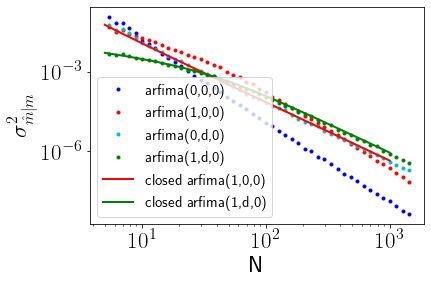

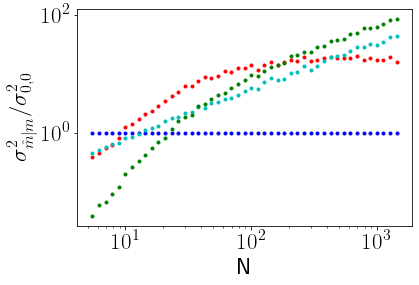

In [7]:
rc('text', usetex=True)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('font', size=23)
rc('axes', labelsize=23)

N2 = np.array([ 5.,    6.,    7.,    8.,    9.,   10.,   11.,   12.,   13.,
         14.,   15.,   16.,   17.,   18.,   19.,   20.,   21.,   22.,
         23.,   24.,   25.,   26.,   27.,   28.,   29.,   30.,   30.,
         32.,   35.,   37.,   40.,   43.,   46.,   50.,   53.,   57.,
         61.,   66.,   71.,   76.,   82.,   88.,   94.,  101.,  109.,
        117.,  126.,  135.,  145.,  156.,  167.,  180.,  193.,  207.,
        223.,  239.,  257.,  276.,  296.,  318.,  342.,  367.,  394.,
        424.,  455.,  489.,  525.,  564.,  606.,  651.,  699.,  751.,
        807.,  867.,  931., 1000.])

y1 = np.array([0.057906,0.0375814,0.0262378,0.019289,0.0147374,0.011601,0.00935243,0.007688,0.00642316,
       0.00544057,0.00466284,0.00403724,0.00352693,0.00310549,0.00275363,0.002457,0.00220474,
       0.00198852,0.00180187,0.00163968,0.00149792,0.00137332,0.00126327,0.0011656,0.00107856,
       0.00100067,0.00100067,0.000867638,0.000711816,0.000629624,0.000530092,0.000451913,0.000389453,
       0.000324048,0.000284988,0.000242764,0.000209065,0.000175754,0.00014964,0.000128812,0.000108965,
       0.0000932731,0.0000806658,0.000068868,0.0000582295,0.0000498239,0.0000423251,0.0000363624,
       0.0000310708,0.0000264524,0.00002276905755900031,0.00001930651472177594,0.00001656008701964897,
       0.00001419517827348953,0.00001205015498672978,0.00001034612823049181,8.81842472542718e-6,
       7.53764691280325e-6,6.46229776377536e-6,5.51928326214902e-6,4.70282913375597e-6,
       4.026673340474608e-6,3.444416803394476e-6,2.930883345498006e-6,2.509429372821242e-6,
       2.141497252940024e-6,1.831655947569794e-6,1.564508706056862e-6,1.335826814077882e-6,
       1.141063785597833e-6,9.75745828626383e-7,8.33253598278761e-7,7.11315083359361e-7,
       6.07492145998289e-7,5.19388594989983e-7,4.43793404251202e-7])

y2 = np.array([0.00508094,0.00444199,0.00395319,0.0035612,0.00323686,0.00296247,0.00272644,0.00252077,
       0.00233969,0.00217889,0.00203508,0.00190569,0.00178865,0.00168231,0.0015853,0.00149647,
       0.00141489,0.00133974,0.00127033,0.00120607,0.00114644,0.001091,0.00103936,0.000991163,
       0.000946117,0.000903947,0.000903947,0.000827297,0.000728635,0.000671893,0.000597859,0.000534823,
       0.000480754,0.000419921,0.000381175,0.000336916,0.00029956,0.000260585,0.000228399,0.000201555,
       0.000174883,0.000152952,0.000134731,0.0001171456358034378,0.0001008012207480144,0.000087529087,
       0.0000753975483512927,0.0000655381909949554,0.0000566180021412759,0.0000486915585965718,
       0.00004226863662758240,0.00003614306201347022,0.00003121981904615726,0.00002693170981398427,
       0.00002300078972863266,0.00001984815167538604,0.00001699787792843522,0.00001458991301105005,
       0.00001255448292790377,0.00001075868680384860,9.19526757050944e-6,7.89411410567072e-6,
       6.76877304463395e-6,5.77231318061351e-6,4.95162471806615e-6,4.256039383500632e-6,
       3.643140512240525e-6,3.114067957993015e-6,2.660674704926291e-6,2.274138002941485e-6,
       1.945734763432544e-6,1.662433679767122e-6,1.419807430829321e-6,1.213079047526026e-6,
       1.037537035625641e-6,8.86828889801254e-7])

f, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=False)
ax.loglog(N[:47], vw[:47], 'b.', lw=2, label='arfima(0,0,0)')
ax.loglog(N[:47], va[:47], 'r.', lw=2, label='arfima(1,0,0)')
ax.loglog(N[:47], vd[:47], 'c.', lw=2, label='arfima(0,d,0)')
#ax.loglog(N[:47], v[:47], 'g.', lw=2, label='arfima(1,d,0)')
ax.loglog(N[:47], vad[:47], 'g.', lw=2, label='arfima(1,d,0)')
ax.loglog(N2, y1, 'r', lw=2, label='closed arfima(1,0,0)')
ax.loglog(N2, y2, 'g', lw=2, label='closed arfima(1,d,0)')
ax.set_xlabel('N')
ax.set_ylabel(r'$\sigma^{2}_{\hat m|m}$')

ax.legend(fontsize=15)

#

vw_ = [i / j for i, j in zip(vw, vw)]
va_ = [i / j for i, j in zip(va, vw)]
vd_ = [i / j for i, j in zip(vd, vw)]
vad_ = [i / j for i, j in zip(vad, vw)]

f, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=False)
ax.loglog(N[:47], vw_[:47], 'b.', lw=2, label='arfima(0,0,0)')
ax.loglog(N[:47], va_[:47], 'r.', lw=2, label='arfima(1,0,0)')
ax.loglog(N[:47], vd_[:47], 'c.', lw=2, label='arfima(0,d,0)')
#ax.loglog(N[:47], v[:47], 'g.', lw=2, label='arfima(1,d,0)')
ax.loglog(N[:47], vad_[:47], 'g.', lw=2, label='arfima(1,d,0)')
ax.set_xlabel('N')
ax.set_ylabel(r'$\sigma^{2}_{\hat m|m}/ \sigma^{2}_{0, 0}$')

#ax.legend(fontsize=15)

[]

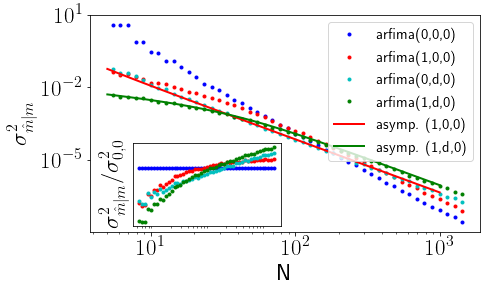

In [284]:
f, ax = plt.subplots(1, 1, figsize=(7, 4), sharey=False)
ax.loglog(N[:47], vw[:47], 'b.', lw=2, label='arfima(0,0,0)')
ax.loglog(N[:47], va[:47], 'r.', lw=2, label='arfima(1,0,0)')
ax.loglog(N[:47], vd[:47], 'c.', lw=2, label='arfima(0,d,0)')
#ax.loglog(N[:47], v[:47], 'g.', lw=2, label='arfima(1,d,0)')
ax.loglog(N[:47], vad[:47], 'g.', lw=2, label='arfima(1,d,0)')
ax.loglog(N2, y1, 'r', lw=2, label='asymp. (1,0,0)')
ax.loglog(N2, y2, 'g', lw=2, label='asymp. (1,d,0)')
ax.set_xlabel('N')
ax.set_ylabel(r'$\sigma^{2}_{\hat m|m}$')

ax.legend(fontsize=15)

#

vw_ = [i / j for i, j in zip(vw, vw)]
va_ = [i / j for i, j in zip(va, vw)]
vd_ = [i / j for i, j in zip(vd, vw)]
vad_ = [i / j for i, j in zip(vad, vw)]

ins = ax.inset_axes([0.11,0.03,0.38,0.38]) #[0.03,0.03,0.38,0.38]

ins.loglog(N[:47], vw_[:47], 'b.', lw=2, label='arfima(0,0,0)')
ins.loglog(N[:47], va_[:47], 'r.', lw=2, label='arfima(1,0,0)')
ins.loglog(N[:47], vd_[:47], 'c.', lw=2, label='arfima(0,d,0)')
ins.loglog(N[:47], vad_[:47], 'g.', lw=2, label='arfima(1,d,0)')
#ins.set_xlabel('N')
ins.set_ylabel(r'$\sigma^{2}_{\hat m|m}/ \sigma^{2}_{0, 0}$')
ins.set_xticks([])
ins.set_yticks([])

#f.savefig('signifance_arfima_length.png', format='png', dpi=120, bbox_inches="tight")

### True python code

In [4]:
def lin_trend(y, plot=False):
    x = np.arange(len(y))
    X_l = sm.add_constant(x)
    res = sm.OLS(y, X_l).fit()

    if plot==True:
        pred_ols = res.get_prediction()
        iv_l = pred_ols.summary_frame()["obs_ci_lower"]
        iv_u = pred_ols.summary_frame()["obs_ci_upper"]

        f, ax = plt.subplots(figsize=(0.9*6, 0.9*4))
        ax.plot(x, y, "-", linewidth=0.2, label="data")
        ax.axhline(0, color='k', ls='--', alpha=0.5)
        ax.plot(x, res.fittedvalues, "r-", linewidth=2, label="OLS") #r--.
        ax.plot(x, iv_u, "r--")
        ax.plot(x, iv_l, "r--")
        ax.legend(loc="best")

    return(res.params[1])

In [5]:
#N = [pow(10, i/19) for i in range(14,70)] # 64
#N = [pow(10, i/19) for i in range(14,58)]
N = [pow(10, i/19) for i in range(14,62)]

Nc = 1000
vw = []

#white noise
for i in range(len(N)):
    Ni=int(N[i])
    p = []
    
    for j in range(Nc):
        y = np.random.normal(0, 1, Ni) 
        y = y - np.mean(y)
        y = y/np.std(y)
        
        trend = lin_trend(y)
        p.append(trend) 
        
    vw.append(np.var(p))
    
#AR(1)

#a = 0.609 
a = 0.95
va = []

for i in range(len(N)):
    Ni=int(N[i])
    p = []
    
    for j in range(Nc):
        
        y = arfima([a], 0, [], Ni, warmup=2**4)
        y=y-np.mean(y)
        y=y*sqrt(1 - a**2)
        
        trend = lin_trend(y)
        p.append(trend) 

    va.append(np.var(p))
    
def f_ar(N, a):                               
    x = - 1/((a-1)**4)/((N**6)-2*(N**4)+(N**2))*(12*((a-1)**3)*(1+a)*(N**3) + 72*a*((a-1)**2)*(N**2)
        - 12*((a-1)**3)*(a+1)*N - 72*a*((1+a)**2) + 72*(a**(N+1))*((1-a)*N+1+a)**2)
    return(x) 
    
v = [f_ar(x, a) for x in N]       ### !!! ### !!! ### !!! ###

# arfima(0,d,0)

#d = 0.76 - 0.5 # d = 0.4 origin unknown
d = 0.45
vd = []

for i in range(len(N)):
    Ni=int(N[i])
    p = []
    
    for j in range(Nc):
        
        y = arfima([], d, [], Ni, warmup=2**4)
        y=y-np.mean(y)
        y=y/sqrt(gamma(1-2*d)/gamma(1-d)**2) #*sqrt(1 - a**2)
        
        trend = lin_trend(y)
        p.append(trend) 

    vd.append(np.var(p))

# arfima(1,d,0)

vad = []
rho=((1 + a**2)*sc.hyp2f1(1,d,1-d,a) - 1)/a/(2*sc.hyp2f1(1,d,1-d,a)-1)

for i in range(len(N)):
    Ni=int(N[i])
    p = []
    
    for j in range(Nc):
        
        y = arfima([a], d, [], Ni, warmup=2**4)
        y=y-np.mean(y)
        y=y / sqrt(gamma(1-2*d) / gamma(1-d)**2 / (1 + a**2 - 2*a*rho))
        
        trend = lin_trend(y)
        p.append(trend) 

    vad.append(np.var(p))

In [6]:
def asymp(a, d, T):
    
    f = ((1+a)/((1-a)*(2*sc.hyp2f1(1,d,1-d,a) - 1)))*((36*(1-2*d)*gamma(1-d))/(d*(1+2*d)*(3+2*d)*gamma(d)))
    var = f*(T**(2*d-3))
    
    return(var)

In [7]:
def closed(a, d, N):
    
    S = lambda i : sum([k**i for k in range(1,N+1)]) 

    ak = lambda k : (S(0)*k - S(1))/(S(0)*S(2) - S(1)**2)
    
    rho1 = ((1 + a**2)*sc.hyp2f1(1,d,1-d,a) - 1)/(a*(2*sc.hyp2f1(1,d,1-d,a) - 1))
    
    var0d = (1/(d*(1 + 2*d)*(3 + 2*d))) \
            *(1/(gamma(1 - 2*d)*gamma(d)*gamma(N-d)*(N**6 - 2*N**4 + N**2))) \
            *(-36*gamma(N+d)*gamma(1-d)*gamma(1-2*d) \
            *((-1 + 2*d)*N**3 + d*(2*d - 1)*N**2 + N+d) + 12*gamma(N-d)*gamma(1-2*d) \
            *((3 + 8*d + 4*(d**2))*(d*gamma(d) - gamma(1+d))*N**3 \
            + 3*d*(3+2*d)*gamma(1+d)*N**2 - (3 + 8*d + 4*d**2) \
            *(d*gamma(d) - gamma(1+d))*N - 3*d*gamma(1+d)))
    
    P = lambda s : (1/((N**2)*(N**2 - 1)**2))*(24*s**3 \
                    + (12 - 36*N**2)*s + (12*N**3 - 12*N))
    
    C1 = lambda s : (gamma(s+d)*gamma(1-d)/  \
                     (gamma(s+1-d)*gamma(d)))*(1 + a**2 - 2*a*rho1)
    
    C = lambda s : (C1(s)/(1 - a**2))*(sc.hyp2f1(1,d+s,1-d+s,a) \
                                       + sc.hyp2f1(1,d-s,1-d-s,a) - 1)
     
    A = a*((144/((N**2)*(N**2 - 1)**2))*sum([C1(s)*s for s in range(1,N)])  # a?
          + a*(C(0) - C(N-1)*N + C(N)*(N-1)) + C(0)*P(1) - C(N-1)*P(N) \
           + C(N)*P(N-1) - C(1)*P(0) )  
    
    var1d = ((1 + a**2 - 2*a*rho1)/(1-a)**2)*var0d + (2/(1-a)**2)*A \
             - (2*a*(1-rho1)/((1 + a**2 - 2*a*rho1)*(1-a)**2))  \
             *C1(0)*sum([ak(k)**2 for k in range(1,N+1)])
    
    return(var1d)

In [8]:
# rescaled arfima(0,d,0)
vd_res = []

for i in range(len(N)):
    Ni=int(N[i])
    p = []
    
    for j in range(Nc):
        
        y = arfima([], d, [], Ni, warmup=2**4)
        y=y-np.mean(y)
        y=0.1*y/sqrt(gamma(1-2*d)/gamma(1-d)**2) 
        
        trend = lin_trend(y)
        p.append(trend) 

    vd_res.append(np.var(p))

1496
1496


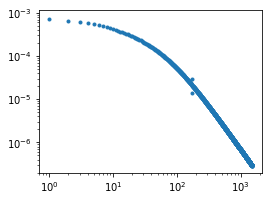

In [9]:
df=pd.read_csv("/Users/tphillips/Atmospheric time series/arfima1d0_closed3.txt",sep='\t',header=None)
                                                     #linear_Dm _Dadd _per.txt
df.columns=['eqm_ad']
eqm_ad = np.array(df['eqm_ad'])  ### !!! ### !!! ### !!! ###
# df['P'].str[:10].astype(float)

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharey='row')
ax.loglog(eqm_ad, '.')
Nm = np.arange(5,1501,1)

In [30]:
Nm2 = np.arange(5,1501,10) # matches to eqm_ad[::4]

Nc = 1000
vw2 = []

#white noise
for i in range(len(Nm2)):
    Ni=int(Nm2[i])
    p = []
    
    for j in range(Nc):
        y = np.random.normal(0, 1, Ni) 
        y = y - np.mean(y)
        y = y/np.std(y)
        
        trend = lin_trend(y)
        p.append(trend) 
        
    vw2.append(np.var(p))

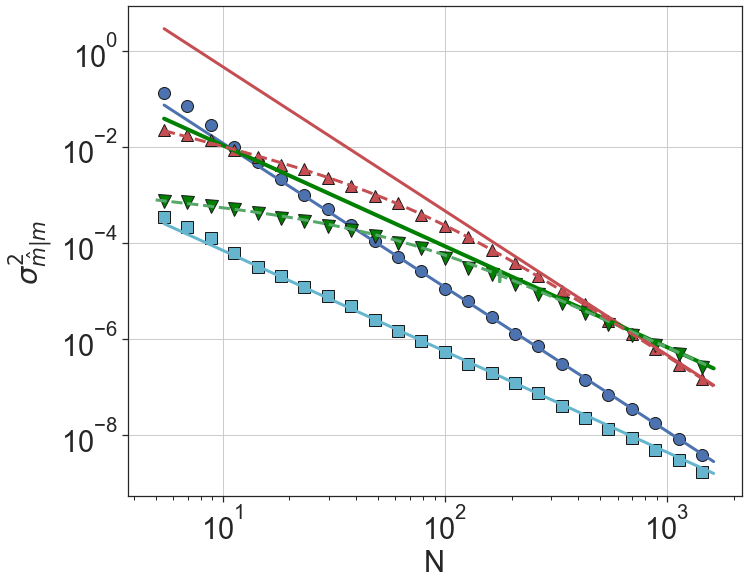

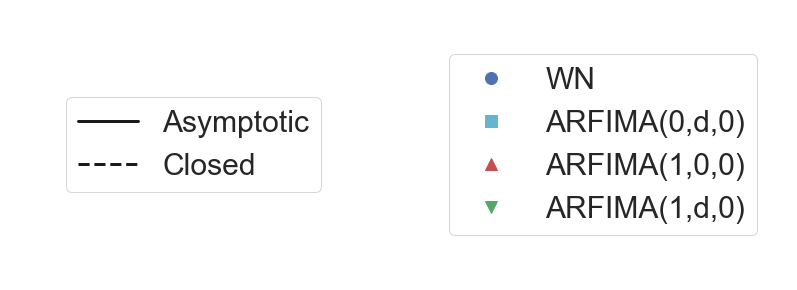

In [108]:
# same as below with analytics from Mathematica (final) :)

params = {'xtick.labelsize': 29, 
          'ytick.labelsize': 29,
          'legend.fontsize': 28,
          'axes.labelsize': 29,
          'font.size': 29,
          'legend.handlelength': 2}

sns.set_theme(style="ticks", rc=params)
sns.mpl.rc("figure", figsize=(6, 6))

a, d = 0.95, 0.45

eq4 = [asymp(0, 0.001, t) for t in N]
eq4a = [asymp(a, 0.001, t) for t in N]
eq4d = [asymp(0, d, t) for t in N]
eq4ad = [asymp(a, d, t) for t in N]

f, ax = plt.subplots(1, 1, figsize=(11, 9), sharey='row') # 11, 5.4 # 11, 4.2
s, l = 12, 3

ax.set_xlabel('N')
ax.set_ylabel(r'$\sigma^{2}_{\hat m|m}$')
ax.set_yticks([1e-1, 1e-5])
#ax.grid()
ax.loglog(N[::2], vw[::2], 'bo', markersize=s, mec = 'k', label='arfima(0,0,0)') 
ax.loglog(N, eq4, 'b-', lw=l)
ax.loglog(N[::2], va[::2], 'r^', markersize=s, mec = 'k', alpha=1, label='arfima(1,0,0)') # , alpha=0.2, label='arfima(1,0,0)'
ax.loglog(N[::2], vad[::2], 'v', color='green', alpha=1, markersize=s+1, mec = 'k', label='arfima(1,d,0)') # alpha=0.2
ax.loglog(N, eq4a, 'r-', alpha=1, lw=l)
ax.loglog(N, eq4ad, '-', color='green', alpha=1, lw=4) # , alpha=0.2, lw=4 # alpha=0.55

#eq4d = [(0.1**2)*asymp(0, d, t) for t in N]
ax.loglog(N[::2], vd_res[::2], 'cs', markersize=s, mec = 'k', label='arfima(0,d,0)')
#ax.loglog(N, eq4d, 'c-', lw=l, label='asymptotic')
ax.loglog(N, 0.01*np.array(eq4d), 'c-', lw=l, label='asymptotic')

#ax.loglog(N, vad, 'g--', lw=l, label='closed')
ax.loglog(Nm, eqm_ad, 'g--', lw=l, label='closed')
ax.loglog(N, v, 'r--', lw=l, alpha=1, label='closed')
ax.grid()

f.savefig('analyt_var_drescale2_mathematica.png', format='png', dpi=120, bbox_inches="tight")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.8, 4.7), sharey='row')

ax1.axis('off')
ax1.plot([], 'k-', lw=l, label='Asymptotic')
ax1.plot([], 'k--', lw=l, label='Closed')
ax1.legend(loc='center', fontsize=30)

ax2.axis('off')

ax2.plot([], 'bo', markersize=s, label='WN') 
ax2.plot([], 'cs', markersize=s, label='ARFIMA(0,d,0)')
ax2.plot([], 'r^', markersize=s, label='ARFIMA(1,0,0)')
ax2.plot([], 'gv', markersize=s, label='ARFIMA(1,d,0)')
#ax2.plot([], 'k-', lw=l, label='Asymptotic')
#ax2.plot([], 'k--', lw=l, label='Closed')
ax2.legend(loc='center', fontsize=30)

f.tight_layout()

#f.savefig('analyt_var_drescale_2.png', format='png', dpi=120, bbox_inches="tight")

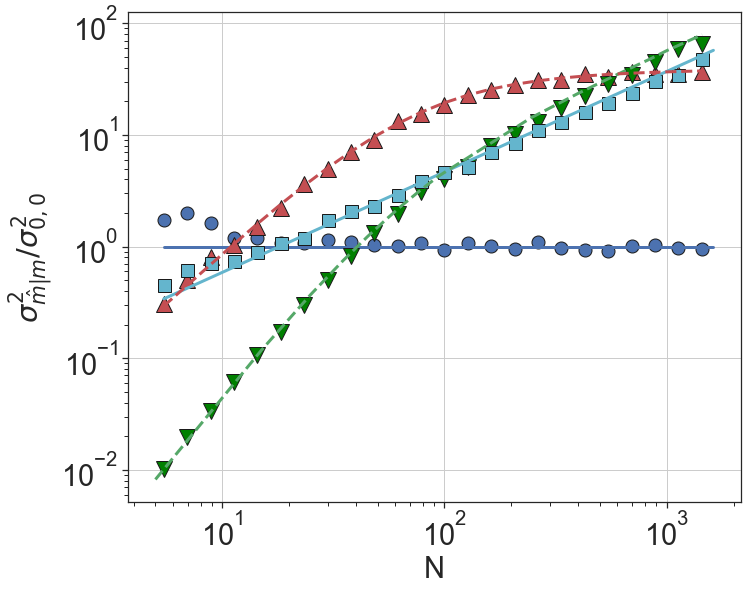

In [107]:
# (final 2) normalized with white noise :)

eq4 = [asymp(0, 0.00001, t) for t in N]
Nm2 = np.arange(5,1501,10)
eq42 = [asymp(0, 0.00001, t) for t in Nm2]

vw_  = [i / j for i, j in zip(vw, eq4)] # zip(vw, vw)
va_  = [i / j for i, j in zip(va, eq4)]
vd_  = [i / j for i, j in zip(vd, eq4)]
vad_ = [i / j for i, j in zip(vad, eq4)]

eq4_   = [i / j for i, j in zip(eq4, eq4)]
eq4a_  = [i / j for i, j in zip(eq4a, eq4)]
eq4d_  = [i / j for i, j in zip(eq4d, eq4)]
eq4ad_ = [i / j for i, j in zip(eq4ad, eq4)]

###v = [f_ar(x, a) for x in N]

v_ = [i / j for i, j in zip(v, eq4)]
eqm_ad_ = [i / j for i, j in zip(eqm_ad[::10], eq42)]

sns.set_theme(style="ticks", rc=params)

f, ax = plt.subplots(1, 1, figsize=(11, 9), sharey='row') # 11, 5.4 # 11, 4.2
s, l = 12, 3

ax.set_xlabel('N')
ax.set_ylabel(r'$\sigma^{2}_{\hat m|m}/ \sigma^{2}_{0, 0}$')
ax.set_yticks([1e-1, 1e-5])
#ax.grid()
ax.loglog(N[::2], vw_[::2], 'bo', markersize=13, mec = 'k', label='arfima(0,0,0)') 
ax.loglog(N, eq4_, 'b-', lw=l)
ax.loglog(N[::2], va_[::2], 'r^', markersize=16, mec = 'k', alpha=1, label='arfima(1,0,0)') # , alpha=0.2, label='arfima(1,0,0)'
ax.loglog(N[::2], vad_[::2], 'v', color='green', alpha=1, markersize=16, mec = 'k', label='arfima(1,d,0)') # alpha=0.2
#ax.loglog(N, eq4a_, 'r-', alpha=1, lw=l)
#ax.loglog(N, eq4ad_, '-', color='green', alpha=1, lw=4) # , alpha=0.2, lw=4 # alpha=0.55

#eq4d = [(0.1**2)*asymp(0, d, t) for t in N]
ax.loglog(N[::2], vd_[::2], 'cs', markersize=13, mec = 'k', label='arfima(0,d,0)')
#ax.loglog(N, eq4d, 'c-', lw=l, label='asymptotic')
ax.loglog(N, np.array(eq4d_), 'c-', lw=l, label='asymptotic')

###
p1 = Nm2[:int(len(Nm2)/16)].tolist() 
p2 = Nm2[int(len(Nm2)/16):].tolist()
Nm3 = p1 + p2[::15]

p1 = eqm_ad_[:int(len(eqm_ad_)/16)]
p2 = eqm_ad_[int(len(eqm_ad_)/16):]
eqm_ad_3 = p1 + p2[::15]
###

#ax.loglog(N, vad, 'g--', lw=l, label='closed')
ax.loglog(Nm3, eqm_ad_3, 'g--', lw=l, label='closed')
ax.loglog(N[::2], v_[::2], 'r--', lw=l, alpha=1, label='closed')
ax.grid()

#f.savefig('analyt_var_drescale3_renorm.png', format='png', dpi=120, bbox_inches="tight")


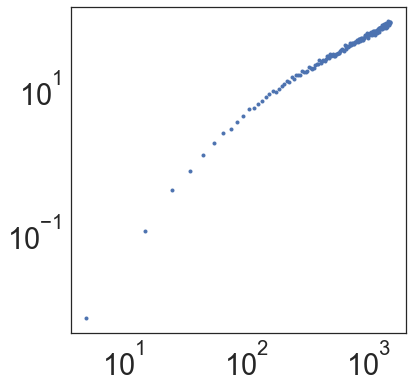

In [55]:
#Nm2

p1 = Nm2[:int(len(Nm2)/2)].tolist() 
p2 = Nm2[int(len(Nm2)/2):].tolist()
Nm3 = p1 + p2[::5]

p1 = eqm_ad_[:int(len(eqm_ad_)/2)].tolist() 
p2 = eqm_ad_[int(len(eqm_ad_)/2):].tolist()
eqm_ad_3 = p1 + p2[::5]




plt.loglog(Nm3, eqm_ad_3, '.') # eqm_ad_

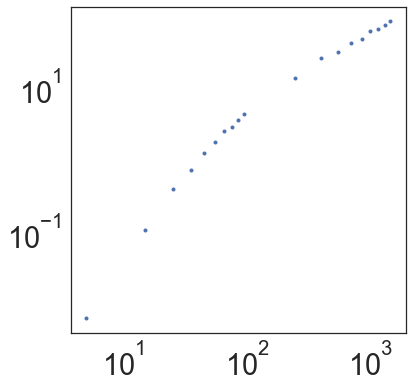

In [87]:
p1 = Nm2[:int(len(Nm2)/16)].tolist() 
p2 = Nm2[int(len(Nm2)/16):].tolist()
Nm3 = p1 + p2[::15]

p1 = eqm_ad_[:int(len(eqm_ad_)/16)]
p2 = eqm_ad_[int(len(eqm_ad_)/16):]
eqm_ad_3 = p1 + p2[::15]

plt.loglog(Nm3, eqm_ad_3, '.') # eqm_ad_

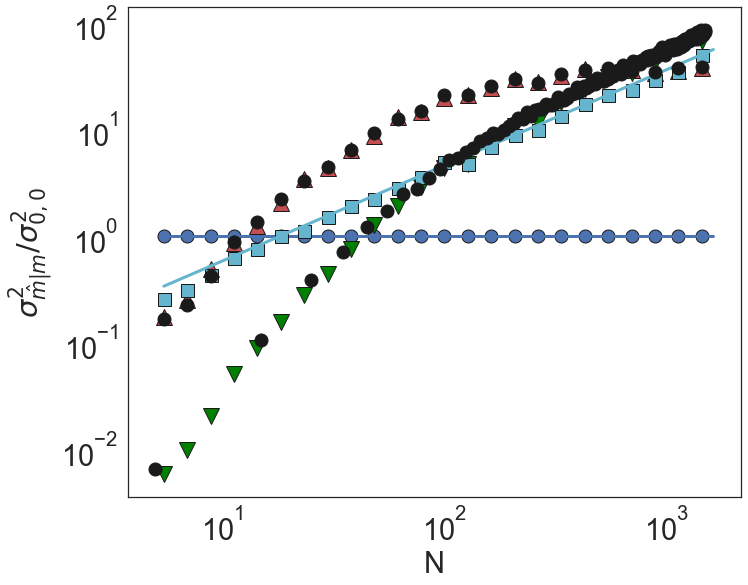

In [44]:
f, ax = plt.subplots(1, 1, figsize=(11, 9), sharey='row') # 11, 5.4 # 11, 4.2
s, l = 12, 3

ax.set_xlabel('N')
ax.set_ylabel(r'$\sigma^{2}_{\hat m|m}/ \sigma^{2}_{0, 0}$')
ax.set_yticks([1e-1, 1e-5])
#ax.grid()
ax.loglog(N[::2], vw_[::2], 'bo', markersize=13, mec = 'k', label='arfima(0,0,0)') 
ax.loglog(N, eq4_, 'b-', lw=l)
ax.loglog(N[::2], va_[::2], 'r^', markersize=16, mec = 'k', alpha=1, label='arfima(1,0,0)') # , alpha=0.2, label='arfima(1,0,0)'
ax.loglog(N[::2], vad_[::2], 'v', color='green', alpha=1, markersize=16, mec = 'k', label='arfima(1,d,0)') # alpha=0.2
#ax.loglog(N, eq4a_, 'r-', alpha=1, lw=l)
#ax.loglog(N, eq4ad_, '-', color='green', alpha=1, lw=4) # , alpha=0.2, lw=4 # alpha=0.55

#eq4d = [(0.1**2)*asymp(0, d, t) for t in N]
ax.loglog(N[::2], vd_[::2], 'cs', markersize=13, mec = 'k', label='arfima(0,d,0)')
#ax.loglog(N, eq4d, 'c-', lw=l, label='asymptotic')
ax.loglog(N, np.array(eq4d_), 'c-', lw=l, label='asymptotic')

#ax.loglog(N, vad, 'g--', lw=l, label='closed')
ax.loglog(Nm2, eqm_ad_, 'ko', markersize=13, label='closed')
ax.loglog(N[::2], v_[::2], 'ko', markersize=13, label='closed')

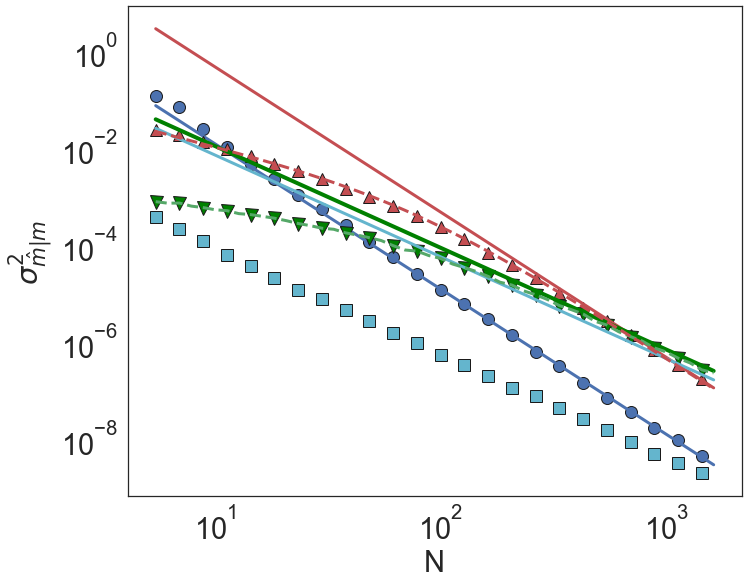

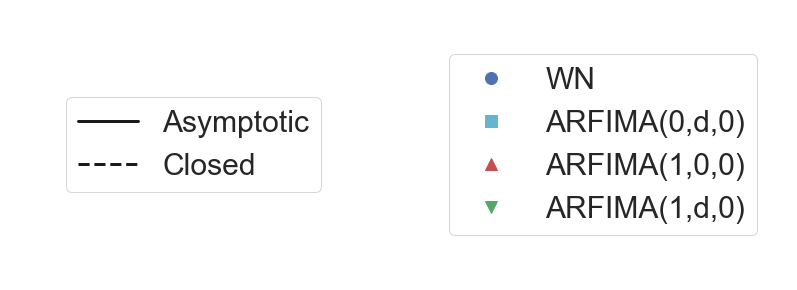

In [19]:
# final without mathematica

params = {'xtick.labelsize': 29, 
          'ytick.labelsize': 29,
          'legend.fontsize': 28,
          'axes.labelsize': 29,
          'font.size': 29,
          'legend.handlelength': 2}

sns.set_theme(style="white", rc=params)
sns.mpl.rc("figure", figsize=(6, 6))

a, d = 0.95, 0.45

eq4 = [asymp(0, 0.001, t) for t in N]
eq4a = [asymp(a, 0.001, t) for t in N]
eq4d = [asymp(0, d, t) for t in N]
eq4ad = [asymp(a, d, t) for t in N]

f, ax = plt.subplots(1, 1, figsize=(11, 9), sharey='row') # 11, 5.4 # 11, 4.2
s, l = 12, 3

ax.set_xlabel('N')
ax.set_ylabel(r'$\sigma^{2}_{\hat m|m}$')
ax.set_yticks([1e-1, 1e-5])
#ax.grid()
ax.loglog(N[::2], vw[::2], 'bo', markersize=s, mec = 'k', label='arfima(0,0,0)') 
ax.loglog(N, eq4, 'b-', lw=l)
ax.loglog(N[::2], va[::2], 'r^', markersize=s, mec = 'k', alpha=1, label='arfima(1,0,0)') # , alpha=0.2, label='arfima(1,0,0)'
ax.loglog(N[::2], vad[::2], 'v', color='green', alpha=1, markersize=s+1, mec = 'k', label='arfima(1,d,0)') # alpha=0.2
ax.loglog(N, eq4a, 'r-', alpha=1, lw=l)
ax.loglog(N, eq4ad, '-', color='green', alpha=1, lw=4) # , alpha=0.2, lw=4 # alpha=0.55

#eq4d = [(0.1**2)*asymp(0, d, t) for t in N]
ax.loglog(N[::2], vd_res[::2], 'cs', markersize=s, mec = 'k', label='arfima(0,d,0)')
ax.loglog(N, eq4d, 'c-', lw=l, label='asymptotic')

ax.loglog(N, vad, 'g--', lw=l, label='closed')
ax.loglog(N, v, 'r--', lw=l, alpha=1, label='closed')

f.savefig('analyt_var_drescale1.png', format='png', dpi=120, bbox_inches="tight")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.8, 4.7), sharey='row')

ax1.axis('off')
ax1.plot([], 'k-', lw=l, label='Asymptotic')
ax1.plot([], 'k--', lw=l, label='Closed')
ax1.legend(loc='center', fontsize=30)

ax2.axis('off')

ax2.plot([], 'bo', markersize=s, label='WN') 
ax2.plot([], 'cs', markersize=s, label='ARFIMA(0,d,0)')
ax2.plot([], 'r^', markersize=s, label='ARFIMA(1,0,0)')
ax2.plot([], 'gv', markersize=s, label='ARFIMA(1,d,0)')
#ax2.plot([], 'k-', lw=l, label='Asymptotic')
#ax2.plot([], 'k--', lw=l, label='Closed')
ax2.legend(loc='center', fontsize=30)

f.tight_layout()

f.savefig('analyt_var_drescale_2.png', format='png', dpi=120, bbox_inches="tight")

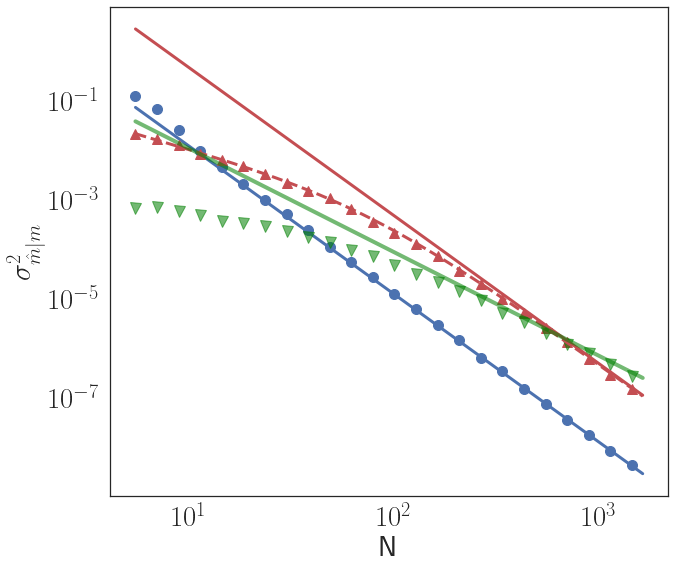

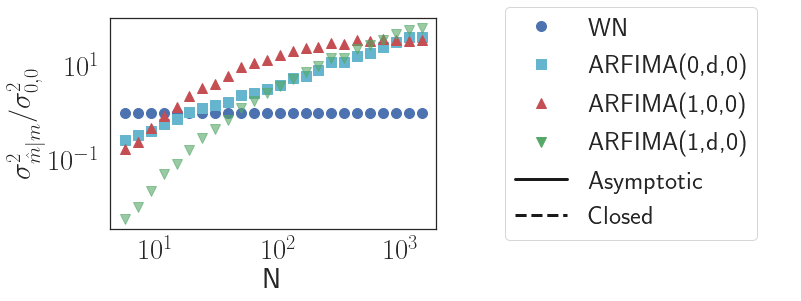

In [72]:
# Good plot, which hopefully will be final plot

rc('text', usetex=True)
rc('xtick', labelsize=29)
rc('ytick', labelsize=29)
rc('font', size=29)
rc('axes', labelsize=29)

#N = [pow(10, i/19) for i in range(14,58)]

eq4 = [asymp(0, 0.001, t) for t in N]
eq4a = [asymp(a, 0.001, t) for t in N]
eq4d = [asymp(0, d, t) for t in N]
eq4ad = [asymp(a, d, t) for t in N]

f, ax = plt.subplots(1, 1, figsize=(10, 9), sharey='row') # 11, 5.4 # 11, 4.2
s, l = 10, 3

ax.set_xlabel('N')
ax.set_ylabel(r'$\sigma^{2}_{\hat m|m}$')
ax.set_yticks([1e-1, 1e-5])
#ax.grid()
ax.loglog(N[::2], vw[::2], 'bo', markersize=s, label='arfima(0,0,0)') 
#ax.loglog(N[::2], vd[::2], 'cs', markersize=8, label='arfima(0,d,0)')
ax.loglog(N, eq4, 'b-', lw=l)
#ax.loglog(N, eq4d, 'c-', lw=2, label='asymptotic')
ax.loglog(N[::2], va[::2], 'r^', markersize=s, label='arfima(1,0,0)')
ax.loglog(N[::2], vad[::2], 'v', color='green', alpha=0.55, markersize=s+1, label='arfima(1,d,0)')
ax.loglog(N, v, 'r--', lw=l, label='closed')
ax.loglog(N, eq4a, 'r-', lw=l)
ax.loglog(N, eq4ad, '-', color='green', alpha=0.55, lw=4)

#f.savefig('var_arfima_len_p1.png', format='png', dpi=120, bbox_inches="tight")

vw_ = [i / j for i, j in zip(vw, vw)]
va_ = [i / j for i, j in zip(va, vw)]
vd_ = [i / j for i, j in zip(vd, vw)]
vad_ = [i / j for i, j in zip(vad, vw)]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.8, 4.7), sharey='row')

ax1.set_xlabel('N')
ax1.set_ylabel(r'$\sigma^{2}_{\hat m|m}/ \sigma^{2}_{0, 0}$')
#ax1.grid()
ax1.loglog(N[::2], vw_[::2], 'bo', markersize=s, label='arfima(0,0,0)') 
ax1.loglog(N[::2], vd_[::2], 'cs', markersize=s, label='arfima(0,d,0)')
ax1.loglog(N[::2], va_[::2], 'r^', markersize=s, label='arfima(1,0,0)')
ax1.loglog(N[::2], vad_[::2], 'gv', markersize=s, alpha=0.6, label='arfima(1,d,0)')

ax2.axis('off')

ax2.plot([], 'bo', markersize=s, label='WN') 
ax2.plot([], 'cs', markersize=s, label='ARFIMA(0,d,0)')
ax2.plot([], 'r^', markersize=s, label='ARFIMA(1,0,0)')
ax2.plot([], 'gv', markersize=s, label='ARFIMA(1,d,0)')
ax2.plot([], 'k-', lw=l, label='Asymptotic')
ax2.plot([], 'k--', lw=l, label='Closed')
ax2.legend(loc='center', fontsize=26)

f.tight_layout()

#f.savefig('var_arfima_len_p2.png', format='png', dpi=120, bbox_inches="tight")

In [9]:
T = 25567

d, a = 0.27254134312763423, 0.7289104180603792 # Ger 
print(asymp(a, d, 25567))
d, a =  0.2532133391562744, 0.7717603625643983     #usa_05
print(asymp(a, d, 25567))
d, a =  0.36876114433354357, 0.7743742999429091    #eur_05
print(asymp(a, d, 25567))
d, a = 0.2209180877105591, 0.748772436322513   #pacific_1
print(asymp(a, d, 25567))
d, a =  0.23895326655285232, 0.7848786897412494 #arc_sea_1
print(asymp(a, d, 25567))

1.6953241750968988e-10
1.4928896001999384e-10
4.813255968742425e-10
9.555871763576222e-11
1.309477176609628e-10


[]

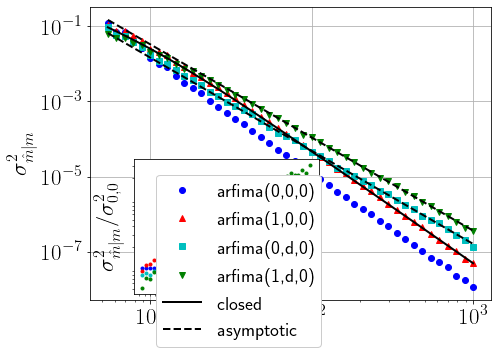

In [11]:
rc('text', usetex=True)
rc('xtick', labelsize=23)
rc('ytick', labelsize=23)
rc('font', size=23)
rc('axes', labelsize=23)

N2 = np.array([ 5.,    6.,    7.,    8.,    9.,   10.,   11.,   12.,   13.,
         14.,   15.,   16.,   17.,   18.,   19.,   20.,   21.,   22.,
         23.,   24.,   25.,   26.,   27.,   28.,   29.,   30.,   30.,
         32.,   35.,   37.,   40.,   43.,   46.,   50.,   53.,   57.,
         61.,   66.,   71.,   76.,   82.,   88.,   94.,  101.,  109.,
        117.,  126.,  135.,  145.,  156.,  167.,  180.,  193.,  207.,
        223.,  239.,  257.,  276.,  296.,  318.,  342.,  367.,  394.,
        424.,  455.,  489.,  525.,  564.,  606.,  651.,  699.,  751.,
        807.,  867.,  931., 1000.])

y2 = np.array([0.00508094,0.00444199,0.00395319,0.0035612,0.00323686,0.00296247,0.00272644,0.00252077,
       0.00233969,0.00217889,0.00203508,0.00190569,0.00178865,0.00168231,0.0015853,0.00149647,
       0.00141489,0.00133974,0.00127033,0.00120607,0.00114644,0.001091,0.00103936,0.000991163,
       0.000946117,0.000903947,0.000903947,0.000827297,0.000728635,0.000671893,0.000597859,0.000534823,
       0.000480754,0.000419921,0.000381175,0.000336916,0.00029956,0.000260585,0.000228399,0.000201555,
       0.000174883,0.000152952,0.000134731,0.0001171456358034378,0.0001008012207480144,0.000087529087,
       0.0000753975483512927,0.0000655381909949554,0.0000566180021412759,0.0000486915585965718,
       0.00004226863662758240,0.00003614306201347022,0.00003121981904615726,0.00002693170981398427,
       0.00002300078972863266,0.00001984815167538604,0.00001699787792843522,0.00001458991301105005,
       0.00001255448292790377,0.00001075868680384860,9.19526757050944e-6,7.89411410567072e-6,
       6.76877304463395e-6,5.77231318061351e-6,4.95162471806615e-6,4.256039383500632e-6,
       3.643140512240525e-6,3.114067957993015e-6,2.660674704926291e-6,2.274138002941485e-6,
       1.945734763432544e-6,1.662433679767122e-6,1.419807430829321e-6,1.213079047526026e-6,
       1.037537035625641e-6,8.86828889801254e-7])

eq4d = [asymp(0, d, t) for t in N]
eq4ad = [asymp(a, d, t) for t in N]

s=1.8
f, ax = plt.subplots(1, 1, figsize=(s*4, s*3), sharey=False)
#ax.loglog(N, vw, 'bo', lw=2, label='arfima(0,0,0)') 
#ax.loglog(N, va, 'r^', lw=2, label='arfima(1,0,0)')
#ax.loglog(N, vd, 'cs', lw=2, label='arfima(0,d,0)')
#ax.loglog(N, vad, 'gv', lw=2, label='arfima(1,d,0)')
#ax.loglog(N, v, 'r', lw=2, label='closed arfima(1,0,0)') 
#ax.loglog(N2, y2, 'g', lw=2, label='closed arfima(1,d,0)')
#ax.loglog(N, eq4d, 'k--', lw=2, label='asymp. arfima(0,d,0)')
#ax.loglog(N, eq4ad, 'k--', lw=2, label='asymp. arfima(1,d,0)')

ax.set_xlabel('N')
ax.set_ylabel(r'$\sigma^{2}_{\hat m|m}$')
ax.set_yticks([1e-1, 1e-5, 1e-9])

ax.grid()

#ax.legend(fontsize=17, loc='upper right')
#ax.legend(fontsize=19, ncol=2, bbox_to_anchor=(0.36, 0.70))

ax.loglog(N, vw, 'bo', lw=2, label='arfima(0,0,0)') 
ax.loglog(N, va, 'r^', lw=2, label='arfima(1,0,0)')
ax.loglog(N, vd, 'cs', lw=2, label='arfima(0,d,0)')
ax.loglog(N, vad, 'gv', lw=2, label='arfima(1,d,0)')
ax.loglog(N, v, 'k-', lw=2, label='closed') 
#ax.loglog(N2, y2, 'k-', lw=2)
ax.loglog(N, eq4d, 'k--', lw=2, label='asymptotic')
ax.loglog(N, eq4ad, 'k--', lw=2)

ax.legend(fontsize=19, bbox_to_anchor=(0.60, 0.46), framealpha=1)

#

vw_ = [i / j for i, j in zip(vw, vw)]
va_ = [i / j for i, j in zip(va, vw)]
vd_ = [i / j for i, j in zip(vd, vw)]
vad_ = [i / j for i, j in zip(vad, vw)]

ins = ax.inset_axes([0.11,0.02,0.46,0.46]) #[0.03,0.03,0.38,0.38]

ins.loglog(N[:47], vw_[:47], 'b.', lw=2, label='arfima(0,0,0)')
ins.loglog(N[:47], va_[:47], 'r.', lw=2, label='arfima(1,0,0)')
ins.loglog(N[:47], vd_[:47], 'c.', lw=2, label='arfima(0,d,0)')
ins.loglog(N[:47], vad_[:47], 'g.', lw=2, label='arfima(1,d,0)')
#ins.set_xlabel('N')
ins.set_ylabel(r'$\sigma^{2}_{\hat m|m}/ \sigma^{2}_{0, 0}$')
ins.set_xticks([])
ins.set_yticks([])

#f.savefig('signifance_arfima_length3.png', format='png', dpi=120, bbox_inches="tight")

/var/folders/nk/h0r67lds3d797555bgntjkz80000gn/T/ipykernel_2816/2356072072.py:9: RuntimeWarning: invalid value encountered in double_scalars
  var0d = (1/(d*(1 + 2*d)*(3 + 2*d))) \
/var/folders/nk/h0r67lds3d797555bgntjkz80000gn/T/ipykernel_2816/2356072072.py:21: RuntimeWarning: overflow encountered in double_scalars
  (gamma(s+1-d)*gamma(d)))*(1 + a**2 - 2*a*rho1)
/var/folders/nk/h0r67lds3d797555bgntjkz80000gn/T/ipykernel_2816/2356072072.py:20: RuntimeWarning: invalid value encountered in double_scalars
  C1 = lambda s : (gamma(s+d)*gamma(1-d)/  \


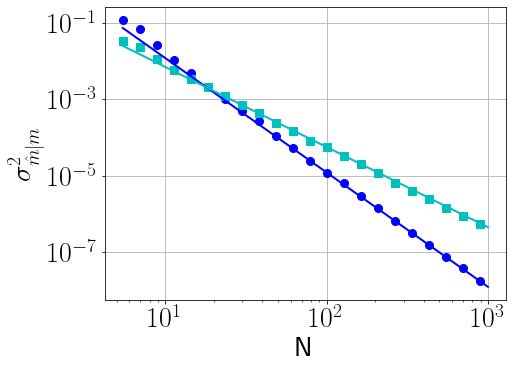

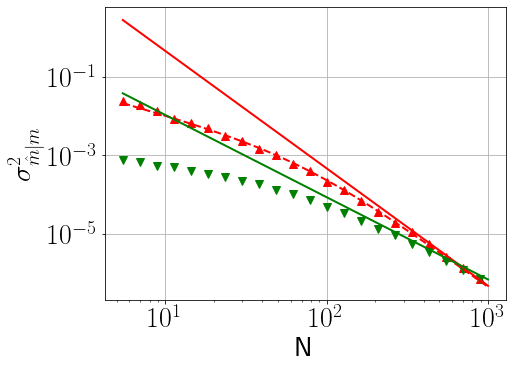

In [11]:
rc('text', usetex=True)
rc('xtick', labelsize=28)
rc('ytick', labelsize=28)
rc('font', size=28)
rc('axes', labelsize=28)

#large params

eq4 = [asymp(0, 0.001, t) for t in N]
eq4a = [asymp(a, 0.001, t) for t in N]
eq4d = [asymp(0, d, t) for t in N]
eq4ad = [asymp(a, d, t) for t in N]

N_int = list(map(round, N))
cl4 = [closed(0.001, 0.001, t) for t in N_int]
cl4a = [closed(a, 0.001, t) for t in N_int]
cl4d = [closed(0.001, d, t) for t in N_int]
cl4ad = [closed(a, d, t) for t in N_int]

s=1.8
f, ax = plt.subplots(1, 1, figsize=(s*4, s*3), sharey=False)

ax.set_xlabel('N')
ax.set_ylabel(r'$\sigma^{2}_{\hat m|m}$')
ax.set_yticks([1e-1, 1e-5, 1e-9])

ax.grid()

ax.loglog(N[::2], vw[::2], 'bo', markersize=8, label='arfima(0,0,0)') 
#ax.loglog(N[::2], va[::2], 'r^', markersize=8, label='arfima(1,0,0)')
ax.loglog(N[::2], vd[::2], 'cs', markersize=8, label='arfima(0,d,0)')
#ax.loglog(N[::2], vad[::2], 'gv', markersize=8, label='arfima(1,d,0)')
#ax.loglog(N, v, 'k-', lw=2, label='closed')

ax.loglog(N, eq4, 'b-', lw=2)
#ax.loglog(N, eq4a, 'r-', lw=2)
ax.loglog(N, eq4d, 'c-', lw=2, label='asymptotic')
#ax.loglog(N, eq4ad, 'g-', lw=2)

#ax.legend(fontsize=19, bbox_to_anchor=(0.60, 0.46), framealpha=1)
#------------------------

f, ax = plt.subplots(1, 1, figsize=(s*4, s*3), sharey=False)

ax.set_xlabel('N')
ax.set_ylabel(r'$\sigma^{2}_{\hat m|m}$')
ax.set_yticks([1e-1, 1e-5, 1e-9])

ax.grid()

#ax.loglog(N[::2], vw[::2], 'bo', markersize=8, label='arfima(0,0,0)') 
ax.loglog(N[::2], va[::2], 'r^', markersize=8, label='arfima(1,0,0)')
#ax.loglog(N[::2], vd[::2], 'cs', markersize=8, label='arfima(0,d,0)')
ax.loglog(N[::2], vad[::2], 'gv', markersize=8, label='arfima(1,d,0)')
ax.loglog(N, v, 'r--', lw=2, label='closed')

#ax.loglog(N, eq4, 'b-', lw=2)
ax.loglog(N, eq4a, 'r-', lw=2)
#ax.loglog(N, eq4d, 'c-', lw=2, label='asymptotic')
ax.loglog(N, eq4ad, 'g-', lw=2)

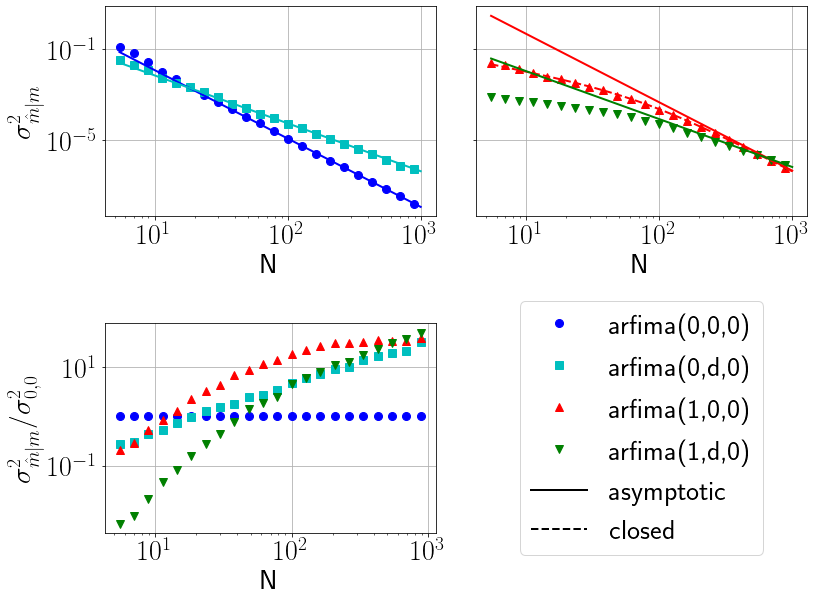

In [163]:
s=3
f, ax = plt.subplots(2, 2, figsize=(s*4, s*3), sharey='row')

ax[0,0].set_xlabel('N')
ax[0,0].set_ylabel(r'$\sigma^{2}_{\hat m|m}$')
ax[0,0].set_yticks([1e-1, 1e-5])
ax[0,0].grid()
ax[0,0].loglog(N[::2], vw[::2], 'bo', markersize=8, label='arfima(0,0,0)') 
ax[0,0].loglog(N[::2], vd[::2], 'cs', markersize=8, label='arfima(0,d,0)')
ax[0,0].loglog(N, eq4, 'b-', lw=2)
ax[0,0].loglog(N, eq4d, 'c-', lw=2, label='asymptotic')

ax[0,1].set_xlabel('N')
ax[0,1].grid()
ax[0,1].loglog(N[::2], va[::2], 'r^', markersize=8, label='arfima(1,0,0)')
ax[0,1].loglog(N[::2], vad[::2], 'gv', markersize=8, label='arfima(1,d,0)')
ax[0,1].loglog(N, v, 'r--', lw=2, label='closed')
ax[0,1].loglog(N, eq4a, 'r-', lw=2)
ax[0,1].loglog(N, eq4ad, 'g-', lw=2)

#ax[0,1].loglog(N_int, cl4ad, 'g--', lw=2)
#ax[0,0].loglog(N_int, cl4, 'b--', lw=2)
#ax[0,0].loglog(N_int, cl4d, 'c--', lw=2)

vw_ = [i / j for i, j in zip(vw, vw)]
va_ = [i / j for i, j in zip(va, vw)]
vd_ = [i / j for i, j in zip(vd, vw)]
vad_ = [i / j for i, j in zip(vad, vw)]

ax[1,0].set_xlabel('N')
ax[1,0].set_ylabel(r'$\sigma^{2}_{\hat m|m}/ \sigma^{2}_{0, 0}$')
ax[1,0].grid()
ax[1,0].loglog(N[::2], vw_[::2], 'bo', markersize=8, label='arfima(0,0,0)') 
ax[1,0].loglog(N[::2], vd_[::2], 'cs', markersize=8, label='arfima(0,d,0)')
ax[1,0].loglog(N[::2], va_[::2], 'r^', markersize=8, label='arfima(1,0,0)')
ax[1,0].loglog(N[::2], vad_[::2], 'gv', markersize=8, label='arfima(1,d,0)')
#ax[1,0].loglog(N, v, 'r--', lw=2, label='closed')
#ax[1,0].loglog(N, eq4a, 'r-', lw=2)
#ax[1,0].loglog(N, eq4ad, 'g-', lw=2)

ax[1,1].axis('off')
#ax[1,0].legend(fontsize=19, bbox_to_anchor=(2, 1), framealpha=1)

ax[1,1].plot([], 'bo', markersize=8, label='arfima(0,0,0)') 
ax[1,1].plot([], 'cs', markersize=8, label='arfima(0,d,0)')
ax[1,1].plot([], 'r^', markersize=8, label='arfima(1,0,0)')
ax[1,1].plot([], 'gv', markersize=8, label='arfima(1,d,0)')
ax[1,1].plot([], 'k-', lw=2, label='asymptotic')
ax[1,1].plot([], 'k--', lw=2, label='closed')
ax[1,1].legend(loc='center')

f.tight_layout()
#f.savefig('signifance_arfima_len.png', format='png', dpi=120, bbox_inches="tight")

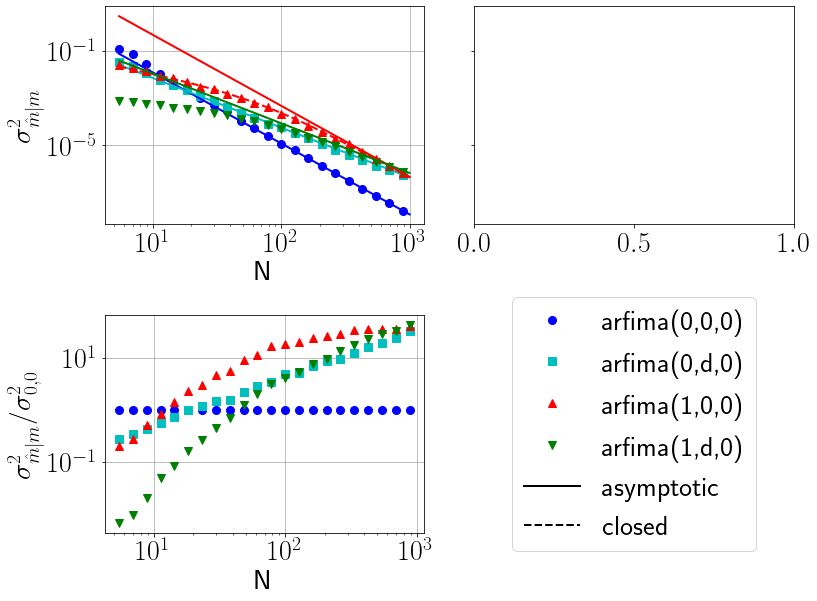

In [16]:
s=3
f, ax = plt.subplots(2, 2, figsize=(s*4, s*3), sharey='row')

ax[0,0].set_xlabel('N')
ax[0,0].set_ylabel(r'$\sigma^{2}_{\hat m|m}$')
ax[0,0].set_yticks([1e-1, 1e-5])
ax[0,0].grid()
ax[0,0].loglog(N[::2], vw[::2], 'bo', markersize=8, label='arfima(0,0,0)') 
ax[0,0].loglog(N[::2], vd[::2], 'cs', markersize=8, label='arfima(0,d,0)')
ax[0,0].loglog(N, eq4, 'b-', lw=2)
ax[0,0].loglog(N, eq4d, 'c-', lw=2, label='asymptotic')
ax[0,0].loglog(N[::2], va[::2], 'r^', markersize=8, label='arfima(1,0,0)')
ax[0,0].loglog(N[::2], vad[::2], 'gv', markersize=8, label='arfima(1,d,0)')
ax[0,0].loglog(N, v, 'r--', lw=2, label='closed')
ax[0,0].loglog(N, eq4a, 'r-', lw=2)
ax[0,0].loglog(N, eq4ad, 'g-', lw=2)

vw_ = [i / j for i, j in zip(vw, vw)]
va_ = [i / j for i, j in zip(va, vw)]
vd_ = [i / j for i, j in zip(vd, vw)]
vad_ = [i / j for i, j in zip(vad, vw)]

ax[1,0].set_xlabel('N')
ax[1,0].set_ylabel(r'$\sigma^{2}_{\hat m|m}/ \sigma^{2}_{0, 0}$')
ax[1,0].grid()
ax[1,0].loglog(N[::2], vw_[::2], 'bo', markersize=8, label='arfima(0,0,0)') 
ax[1,0].loglog(N[::2], vd_[::2], 'cs', markersize=8, label='arfima(0,d,0)')
ax[1,0].loglog(N[::2], va_[::2], 'r^', markersize=8, label='arfima(1,0,0)')
ax[1,0].loglog(N[::2], vad_[::2], 'gv', markersize=8, label='arfima(1,d,0)')

ax[1,1].axis('off')

ax[1,1].plot([], 'bo', markersize=8, label='arfima(0,0,0)') 
ax[1,1].plot([], 'cs', markersize=8, label='arfima(0,d,0)')
ax[1,1].plot([], 'r^', markersize=8, label='arfima(1,0,0)')
ax[1,1].plot([], 'gv', markersize=8, label='arfima(1,d,0)')
ax[1,1].plot([], 'k-', lw=2, label='asymptotic')
ax[1,1].plot([], 'k--', lw=2, label='closed')
ax[1,1].legend(loc='center')

f.tight_layout()

#f.savefig('variance_arfima_len.png', format='png', dpi=120, bbox_inches="tight")

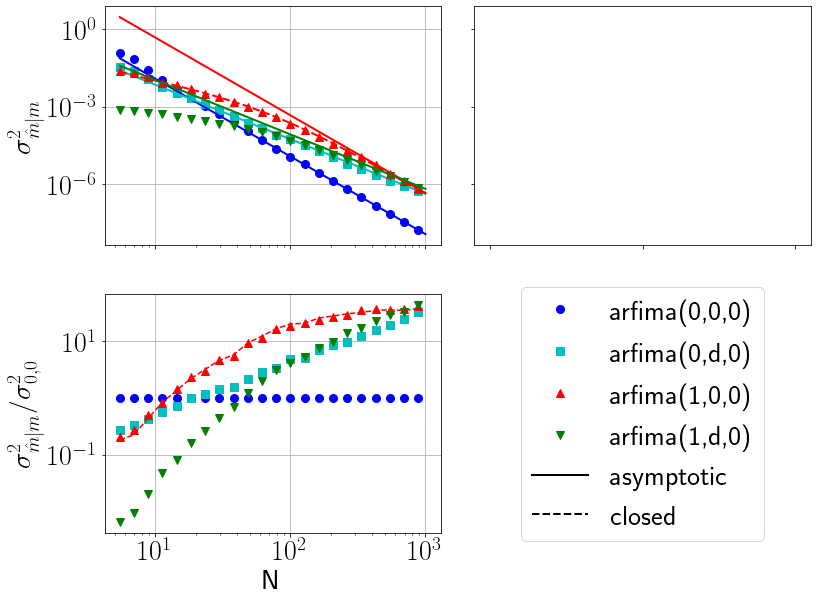

In [12]:
s=3
f, ax = plt.subplots(2, 2, figsize=(s*4, s*3), sharey='row', sharex='col')

ax[0,0].set_ylabel(r'$\sigma^{2}_{\hat m|m}$')
ax[0,0].set_yticks([1e-1, 1e-5])
ax[0,0].grid()
ax[0,0].loglog(N[::2], vw[::2], 'bo', markersize=8, label='arfima(0,0,0)') 
ax[0,0].loglog(N[::2], vd[::2], 'cs', markersize=8, label='arfima(0,d,0)')
ax[0,0].loglog(N, eq4, 'b-', lw=2)
ax[0,0].loglog(N, eq4d, 'c-', lw=2, label='asymptotic')

ax[0,0].loglog(N[::2], va[::2], 'r^', markersize=8, label='arfima(1,0,0)')
ax[0,0].loglog(N[::2], vad[::2], 'gv', markersize=8, label='arfima(1,d,0)')
ax[0,0].loglog(N, v, 'r--', lw=2, label='closed')
ax[0,0].loglog(N, eq4a, 'r-', lw=2)
ax[0,0].loglog(N, eq4ad, 'g-', lw=2)

#ax[0,1].loglog(N_int, cl4ad, 'g--', lw=2)
#ax[0,0].loglog(N_int, cl4, 'b--', lw=2)
#ax[0,0].loglog(N_int, cl4d, 'c--', lw=2)

v_ = [i / j for i, j in zip(v, vw)]

vw_ = [i / j for i, j in zip(vw, vw)]
va_ = [i / j for i, j in zip(va, vw)]
vd_ = [i / j for i, j in zip(vd, vw)]
vad_ = [i / j for i, j in zip(vad, vw)]

ax[1,0].set_xlabel('N')
ax[1,0].set_ylabel(r'$\sigma^{2}_{\hat m|m}/ \sigma^{2}_{0, 0}$')
ax[1,0].grid()
ax[1,0].loglog(N[::2], vw_[::2], 'bo', markersize=8, label='arfima(0,0,0)') 
ax[1,0].loglog(N[::2], vd_[::2], 'cs', markersize=8, label='arfima(0,d,0)')
ax[1,0].loglog(N[::2], va_[::2], 'r^', markersize=8, label='arfima(1,0,0)')
ax[1,0].loglog(N[::2], vad_[::2], 'gv', markersize=8, label='arfima(1,d,0)')

ax[1,0].loglog(N[::2], v_[::2], 'r--', markersize=8)

ax[1,1].axis('off')
ax[1,1].plot([], 'bo', markersize=8, label='arfima(0,0,0)') 
ax[1,1].plot([], 'cs', markersize=8, label='arfima(0,d,0)')
ax[1,1].plot([], 'r^', markersize=8, label='arfima(1,0,0)')
ax[1,1].plot([], 'gv', markersize=8, label='arfima(1,d,0)')
ax[1,1].plot([], 'k-', lw=2, label='asymptotic')
ax[1,1].plot([], 'k--', lw=2, label='closed')
ax[1,1].legend(loc='center')

f.tight_layout()

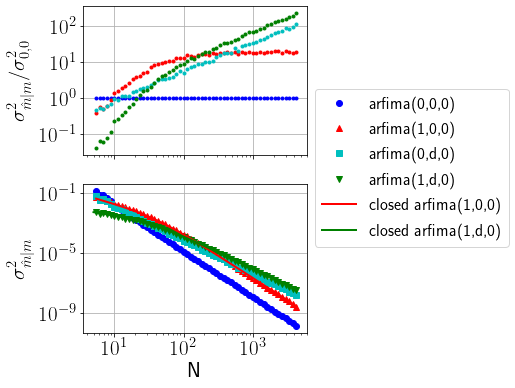

In [30]:
# inner plot

rc('xtick', labelsize=21)
rc('ytick', labelsize=21)
rc('font', size=21)
rc('axes', labelsize=21)

vw_ = [i / j for i, j in zip(vw, vw)]
va_ = [i / j for i, j in zip(va, vw)]
vd_ = [i / j for i, j in zip(vd, vw)]
vad_ = [i / j for i, j in zip(vad, vw)]

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), sharex=True, sharey=False)

ax1.loglog(N, vw_, 'b.', lw=2, label='arfima(0,0,0)')
ax1.loglog(N, va_, 'r.', lw=2, label='arfima(1,0,0)')
ax1.loglog(N, vd_, 'c.', lw=2, label='arfima(0,d,0)')
ax1.loglog(N, vad_, 'g.', lw=2, label='arfima(1,d,0)')
ax1.set_ylabel(r'$\sigma^{2}_{\hat m|m}/ \sigma^{2}_{0, 0}$')
ax1.set_yticks([1e-1, 1e0, 1e1, 1e2])
ax1.grid()

ax2.loglog(N, vw, 'bo', lw=2, label='arfima(0,0,0)')
ax2.loglog(N, va, 'r^', lw=2, label='arfima(1,0,0)')
ax2.loglog(N, vd, 'cs', lw=2, label='arfima(0,d,0)')
ax2.loglog(N, vad, 'gv', lw=2, label='arfima(1,d,0)')
ax2.loglog(N, v, 'r', lw=2, label='closed arfima(1,0,0)') 
ax2.loglog(N2, y2, 'g', lw=2, label='closed arfima(1,d,0)')
ax2.set_xlabel('N')
ax2.set_ylabel(r'$\sigma^{2}_{\hat m|m}$')
ax2.set_yticks([1e-1, 1e-5, 1e-9])
ax2.grid()

ax2.legend(fontsize=17, bbox_to_anchor=(1, 1.7))

f.savefig('variance_arfima_length_a09_d04.png', format='png', dpi=120, bbox_inches="tight")